In [1]:
import numpy as np
import xarray as xr
import json
import os
import socket
import matplotlib.pyplot as plt
import matplotlib.tri as tri

import xmitgcm as xm

from utils_mitgcm import open_mitgcm_ds_from_config

import eddytools as et

In [2]:
model = 'geneva_200m'

In [8]:
str_start_time = "2023-07-01T12:00:00.000000000"
str_end_time = "2023-07-17T00:00:00.000000000"

depth_index=0

outputpath = "../99-Outputs/nencioli/"

# Open MITgcm results

In [9]:
mitgcm_config, ds_to_plot = open_mitgcm_ds_from_config('../config.json', model)

# Preprocess MITgcm inputs

In [10]:
grid_resolution_in_meter = ds_to_plot['XC'].values[1] - ds_to_plot['XC'].values[0]

In [11]:
data_aligned = et.detection_nencioli.preprocess_inputs(str_start_time, str_end_time, ds_to_plot, depth_index)

# Detecting eddies

In [12]:
# Specify parameters for eddy detection
detection_parameters = {
    "model": "MITgcm",
    "grid": "cartesian",
    "hemi": "north",
    "start_time": str_start_time,  # time range start
    "end_time": str_end_time,  # time range end
    "calendar": "standard",  # calendar, must be either 360_day or standard
    "lon1": data_aligned.lon.values.min(),  # minimum longitude of detection region
    "lon2": data_aligned.lon.values.max(),  # maximum longitude
    "lat1": data_aligned.lat.values.min(),  # minimum latitude
    "lat2": data_aligned.lat.values.max(),  # maximum latitude
    "res": grid_resolution_in_meter / 1000,  # resolution of the fields in km
    "min_dep": 1,  # minimum ocean depth where to look for eddies in m
    "no_long": False,  # If True, elongated shapes will not be considered
    "no_two": False,  # If True, eddies with two minima in the OW
    # parameter and a OW > OW_thr in between  will not
    # be considered
    "a": 3, # u/v increase "a" points away from reversal
    "b": 2, # find the velocity minimum within the searching area defined by
            # "b" around the points that satisfy the first two constraints
    "rad": 15, # define the space window in which the algorithm looks for the eddy limits
}

In [13]:
eddies = et.detection_nencioli.detect_UV(data_aligned, detection_parameters, "UVEL", "VVEL", "SPEED", use_bags=True)

Detecting eddies in velocity fields


# Plotting eddies

In [23]:
def plot_map_eddies(snapshot_vel, snapshot_eddies, title, stream_density = 6):
    x_plot, y_plot = np.meshgrid(snapshot_vel['lon'], snapshot_vel['lat'])
    u_plot = snapshot_vel['UVEL'].values
    v_plot = snapshot_vel['VVEL'].values
    
    plt.close('all')
    fig = plt.figure(figsize=(12, 7))

    # Plot background scalar field (e.g., UVEL)
    snapshot_vel["UVEL"].plot()

    # Plot streamlines
    plt.streamplot(x_plot, y_plot, u_plot, v_plot, 
                   density=stream_density, color='black', linewidth=0.5, 
                   arrowsize=0.7, arrowstyle='->')

    # Overlay eddies
    for i in range(len(snapshot_eddies)):
        eddy_i = snapshot_eddies[i]['eddy_i']
        eddy_j = snapshot_eddies[i]['eddy_j']
        lon_eddy = snapshot_vel['lon'].values[eddy_i]
        lat_eddy = snapshot_vel['lat'].values[eddy_j]

        try:
            triang = tri.Triangulation(lon_eddy, lat_eddy)
            plt.tripcolor(triang, facecolors=np.full(len(triang.triangles), 1.0), 
                          cmap=plt.cm.Greens, vmin=0, vmax=4, alpha=1)
        except Exception as e:
            plt.scatter(lon_eddy, lat_eddy, c='green')
        # Eddy center
        plt.scatter(snapshot_eddies[i]['lon'], snapshot_eddies[i]['lat'], c='black')
            # Display winding label
        plt.text(snapshot_eddies[i]['lon'] + 0.1, snapshot_eddies[i]['lat'] + 0.1, str(snapshot_eddies[i]['winding']),
             fontsize=9, color='black', ha='left', va='bottom')

    plt.text(0.02, 0.98, f'Z={round(float(snapshot_vel.Depth.values),2)}m', transform=plt.gca().transAxes, ha='left', va='top')
    plt.title(title)
    
    return fig

In [1]:
eddies[t_plot]

NameError: name 'eddies' is not defined

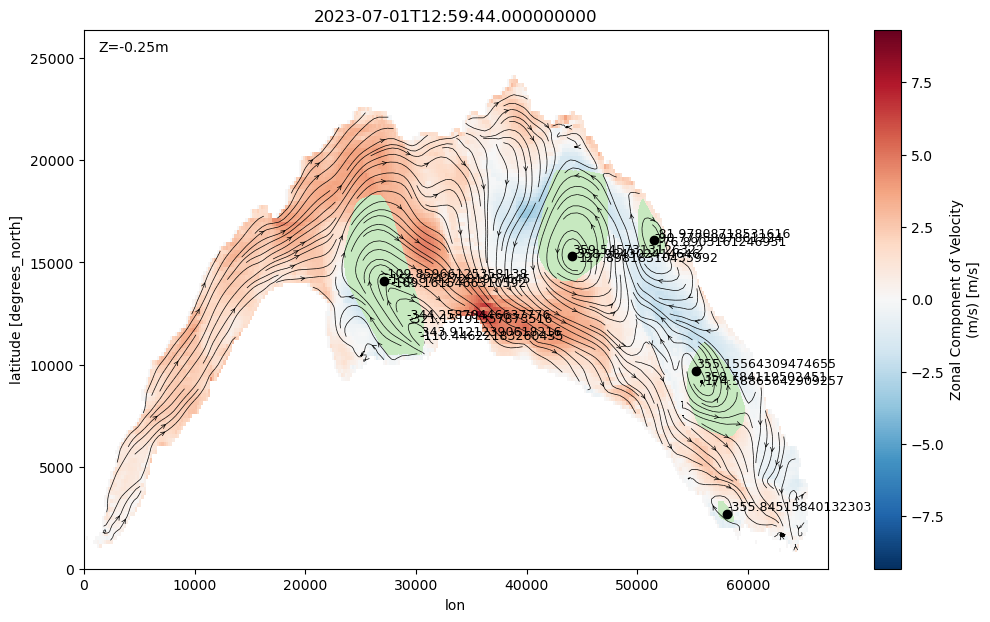

In [24]:
t_plot = 1
fig = plot_map_eddies(data_aligned.isel(time=t_plot), 
                      eddies[t_plot], 
                      str(data_aligned['time'].isel(time=t_plot).values),
                      4 # streamplot density (default=6)
                     )

# Save results

KeyboardInterrupt: 

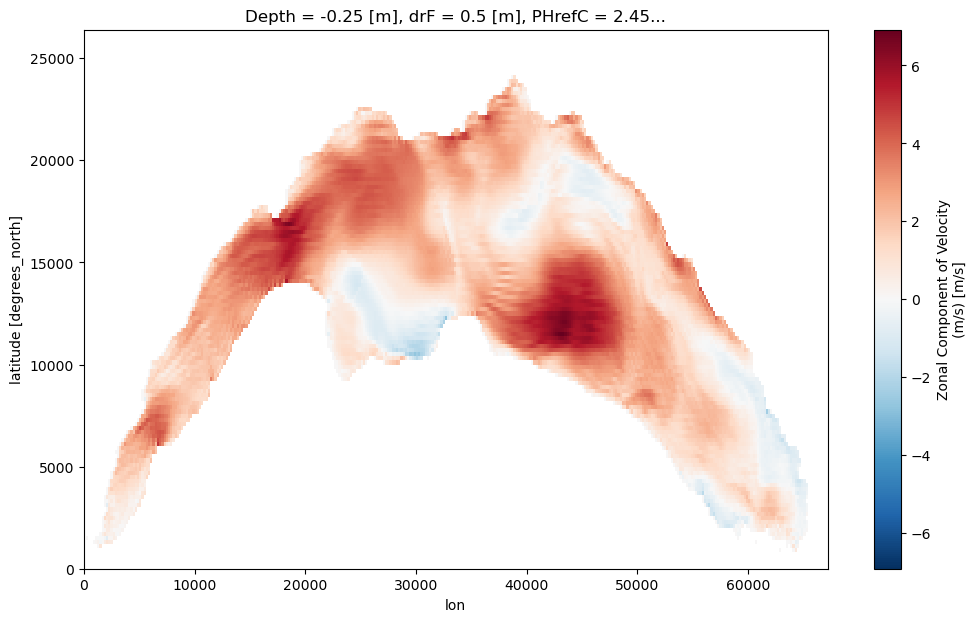

In [15]:
for t_plot in range(0,len(eddies)):
    fig = plot_map_eddies(data_aligned.isel(time=t_plot), 
                          eddies[t_plot], 
                          str(data_aligned['time'].isel(time=t_plot).values),
                          4 # streamplot density (default=6)
                         )
    plt.savefig(rf'../99-Outputs/nencioli/winding_criteria_t{t_plot}')

In [ ]:
eddy_list = []

for eddy_dict in eddies:
    for eddy_id, eddy in eddy_dict.items():
        eddy_list.append({
            'eddy_id': eddy_id,
            'time': eddy['time'],
            'lon': eddy['lon'][0],
            'lat': eddy['lat'][0],
            'amp': eddy['amp'][0],
            'area': eddy['area'][0],
            'scale': eddy['scale'][0][0],
            'type': 1 if eddy['type'] == 'anticyclonic' else -1,
            'lon_eddy': data_aligned.isel(time=0)['lon'].values[eddy['eddy_i']],
            'lat_eddy': data_aligned.isel(time=0)['lat'].values[eddy['eddy_j']]
        })

# Build xarray Dataset properly
eddy_ds = xr.Dataset(
    data_vars={
        'time': ('eddy_id', np.array([e['time'] for e in eddy_list])),
        'lon': ('eddy_id', np.array([e['lon'] for e in eddy_list])),
        'lat': ('eddy_id', np.array([e['lat'] for e in eddy_list])),
        'amp': ('eddy_id', np.array([e['amp'] for e in eddy_list])),
        'area': ('eddy_id', np.array([e['area'] for e in eddy_list])),
        'scale': ('eddy_id', np.array([e['scale'] for e in eddy_list])),
        'type': ('eddy_id', np.array([e['type'] for e in eddy_list])),
    },
    coords={
        'eddy_id': np.array([e['eddy_id'] for e in eddy_list])
    }
)

In [ ]:
eddy_ds.to_netcdf(rf'../99-Outputs/nencioli/winding_criteria_eddies.nc')